<div style="text-align:center; font-family:monospace; border:2px solid black; padding:20px; display:inline-block; background-color:#f9f9f9; border-radius:10px;">
    <p>/////////////////////////////////////////////////////////////////////////////////////////////////</p>
    <p>////              ECOLE NATIONALE DE LA STATISTIQUE ET DE L'ANALYSE ECONOMIQUE PIERRE NDIAYE /////</p>
    <p>////               COURS DE STATISTIQUES EXPLORATOIRE ET SPATIALE - ISE1_CYCLE LONG          /////</p>
    <p>////                ENSEIGNANT : MR HEMA                                                     /////</p>
    <p>////                TP4_PYTHON                                                               /////</p>
    <p>////                MEMBRES :                                                                /////</p>
    <p>//// - FOGWOUNG DJOUFACK SARAH-LAURE                                                         /////</p>
    <p>//// - NGUEMFOUO NGOUMTSA CELINA                                                             /////</p>
    <p>//// - NIASS AHMADOU                                                                         /////</p>
    <p>//// - SENE MALICK                                                                           /////</p>
    <p>/////////////////////////////////////////////////////////////////////////////////////////////////</p>
</div>



<p style="font-size:24px;">L'objectif maintenant c'est de creer une classification des différentes valeurs des zones pour chaque raster, indiquant le taux de prévalence ou la présence de la maladie dans la zone considérée. La classification se fait en déterminant des intervalles avec la moyenne et l'ecart type sur les années.</p>


In [ ]:
# Importation des bibliothèques nécessaires pour le TP
import rasterio #Pour exploiter les rasters de MADAGASCAR
import numpy as np #Pour convertir les rasters en tableau et calculer la moyenne et l'ecart type
import matplotlib.pyplot as plt #Pour la visualisation
from matplotlib_scalebar.scalebar import ScaleBar #La c'est pour la barre de la classification des zones 
from matplotlib.colors import LinearSegmentedColormap #La c'est pour colorer la barre de la classification des zones 
from rasterio.mask import mask #Pour procéder au crop en prenant que les données du Madagascar
import geopandas as gpd #Pour exploiter les shapefiles


In [20]:

# Définition des chemins d'accès aux données
dossier_donnees_madagascar = 'C:/Users/DELL/Desktop/ISEP3/Statistique ES/Data_Sen_and_Madagas/Madagascar/Shapfile/'
cartes_malaria = {}

# Création d'un dictionnaire avec les chemins vers les fichiers TIFF de prévalence du paludisme
# pour chaque année de 2000 à 2022
cartes_malaria = {
    f'carte_malaria_{annee}': f'{dossier_donnees_madagascar}202406_Global_Pf_Parasite_Rate_MDG_{annee}.tiff' 
    for annee in range(2000, 2023)
}

# Chemins vers les shapefiles des différentes divisions administratives
limites_administratives = {}
for niveau in range(4):
    limites_administratives[f'niveau_{niveau}'] = (
        f'C:/Users/DELL/Desktop/ISEP3/Statistique ES/Data_Sen_and_Madagas/Madagascar/Shapfile/mdg_admbnda_adm{niveau}_BNGRC_OCHA_20181031.shp'
    )


<p style="font-size:20px;">Pour ce faire nous allons d'abord commencer par convertir les rasters en tableau pour pouvoir calculer la moyenne et l'ecart type.</p>

In [21]:
# Lecture et traitement des données raster
donnees_prevalence = []  # Liste pour stocker les données de prévalence du malaria

# Lecture de chaque carte de prévalence
for chemin_carte in cartes_malaria.values():
    with rasterio.open(chemin_carte) as carte:
        # Lecture de la bande principale de chaque carte
        donnees_prevalence.append(carte.read(1))

# Création d'un tableau pour les calculs : (nombre_annees, hauteur, largeur)
tableau = np.stack(donnees_prevalence, axis=0)

# Calcul des statistiques 
masque_valeurs_manquantes = np.isnan(tableau)
moyenne_historique = np.nanmean(tableau, axis=0)
ecart_type_historique = np.nanstd(tableau, axis=0)

# Sauvegarde des statistiques calculées
# Utilisation des métadonnées de la première carte comme référence
with rasterio.open(next(iter(cartes_malaria.values()))) as carte_reference:
    parametres_carte = carte_reference.profile
    parametres_carte.update(dtype=rasterio.float32)

# Sauvegarde de la carte des moyennes
with rasterio.open("moyenne_historique_malaria_mdg.tif", "w", **parametres_carte) as carte_sortie:
    carte_sortie.write(moyenne_historique.astype(rasterio.float32), 1)

# Sauvegarde de la carte des écarts-types
with rasterio.open("ecart_type_malaria_mdg.tif", "w", **parametres_carte) as carte_sortie:
    carte_sortie.write(ecart_type_historique.astype(rasterio.float32), 1)

print("Cartes statistiques générées avec succès.")

Cartes statistiques générées avec succès.


<p style="font-size:20px;">Maintenant nous allons définir les intervalles : lorsque la prévalence est inférieure à la moyenne et l'ecart type dejà calculé précédemment  la zone est alors normale maintenant si les la prévalence est entre la moyenne et l'ecart type et moyenne_historique + 2 * ecart_type_historique alors la zone est alerte maintenant si c'est supérieur à moyenne_historique + 2 * ecart_type_historique alors la zone est critique.</p>

<p style="font-size:15px; color:black;">
    Ensuite, nous allons représenter en fonction de la classification : 
    <span style="color:green;">Vert pour risque normal</span>, 
    <span style="color:orange;">Jaune pour risque modéré</span>, et 
    <span style="color:red;">Rouge pour risque critique</span>.
</p>


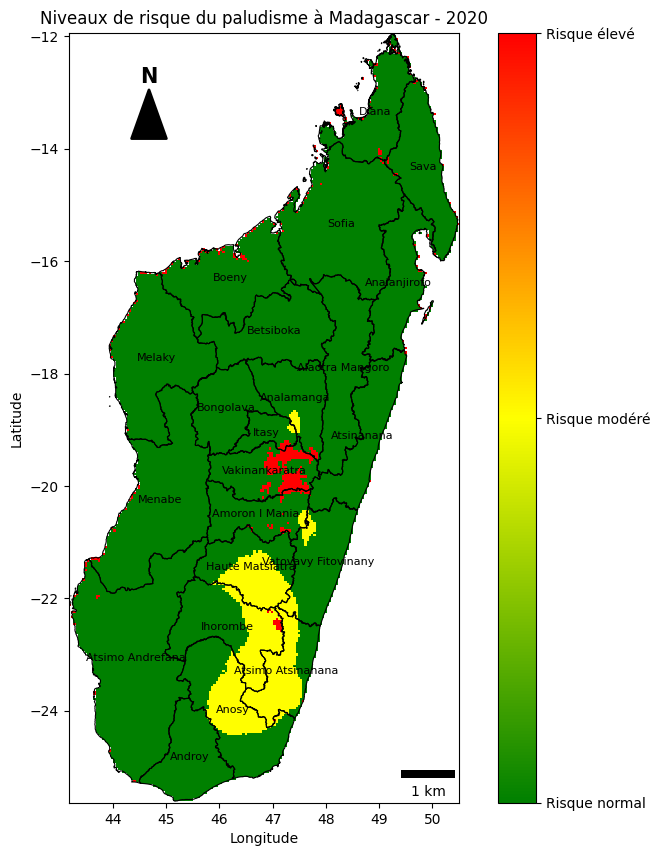

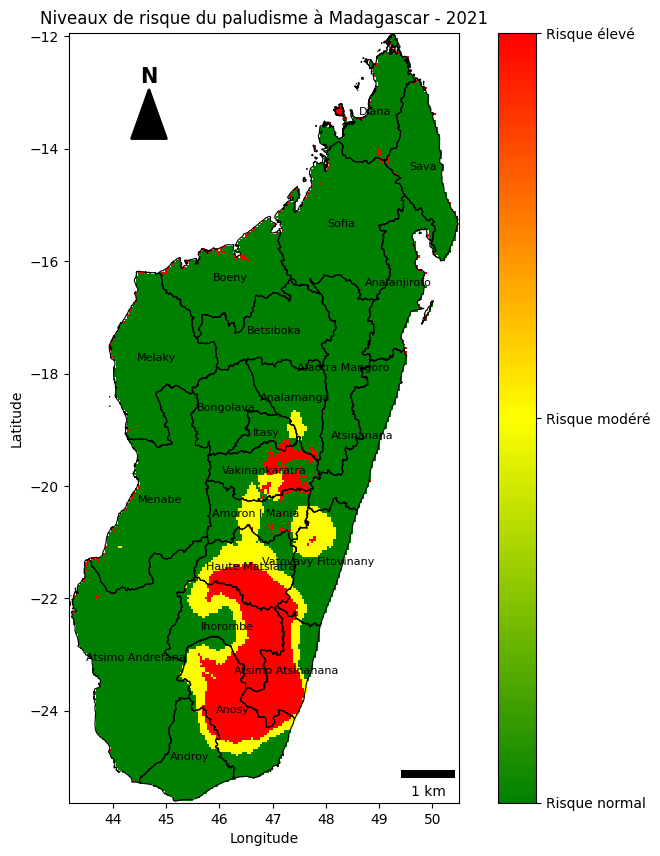

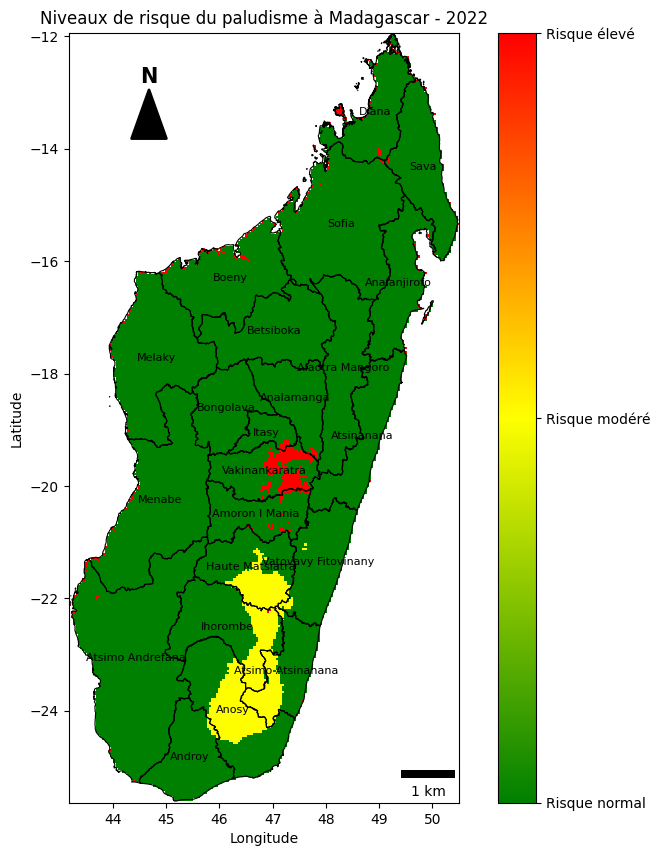

In [22]:

# Analyse des années récentes (2020-2022)
cartes_recentes = {
    2020: cartes_malaria['carte_malaria_2020'],
    2021: cartes_malaria['carte_malaria_2021'],
    2022: cartes_malaria['carte_malaria_2022']
}

# Chargement des limites administratives pour les différents niveaux administratifs 
limites_pays = gpd.read_file(limites_administratives['niveau_0'])
geometrie_madagascar = limites_pays.geometry.values

limites_regions = gpd.read_file(limites_administratives['niveau_1'])

# Définition d'une palette de couleurs pour la classification
palette_risque = LinearSegmentedColormap.from_list("niveaux_risque", ["green", "yellow", "red"])

def ajouter_rose_des_vents(ax, x, y, taille=1, texte="N", taille_texte=12):
    """Ajoute une rose des vents sur la carte."""
    # Flèche principale (Nord)
    ax.annotate('', xy=(x, y + taille), xytext=(x, y),
                arrowprops=dict(facecolor='black', edgecolor='black',
                                linewidth=2, headwidth=25, headlength=35, width=5))
    # Ligne du Sud
    ax.annotate('', xy=(x, y), xytext=(x, y - taille * 0.2),
                arrowprops=dict(facecolor='black', edgecolor='black',
                                linewidth=1, headwidth=0, headlength=0, width=1))
    # Texte "N"
    ax.text(x, y + taille + 0.05, texte, ha='center', va='bottom', 
            fontsize=taille_texte, fontweight='bold')

# Analyse et visualisation pour chaque année récente
for annee, chemin_carte in cartes_recentes.items():
    with rasterio.open(chemin_carte) as carte:
        # Extraction des données pour Madagascar uniquement
        try:
            donnees_annee, transformation = mask(carte, geometrie_madagascar, crop=True, nodata=np.nan)
            donnees_annee = donnees_annee[0]
        except ValueError as e:
            print(f"Erreur lors du traitement de l'année {annee}: {e}")
            continue

        # Classification des zones selon le niveau de risque
        zone_normale = np.where(donnees_annee < (moyenne_historique + ecart_type_historique), 0, np.nan)
        zone_alerte = np.where(
            (donnees_annee >= moyenne_historique + ecart_type_historique) & 
            (donnees_annee < moyenne_historique + 2 * ecart_type_historique), 1, np.nan
        )
        zone_critique = np.where(donnees_annee >= (moyenne_historique + 2 * ecart_type_historique), 2, np.nan)
        
        # Création de la carte de classification finale
        carte_risque = np.full_like(donnees_annee, np.nan)
        carte_risque[zone_normale == 0] = 0
        carte_risque[zone_alerte == 1] = 1
        carte_risque[zone_critique == 2] = 2

        # Définition de l'étendue géographique
        etendue_carte = (
            transformation[2],
            transformation[2] + transformation[0] * carte_risque.shape[1],
            transformation[5] + transformation[4] * carte_risque.shape[0],
            transformation[5]
        )

        # Création de la visualisation
        fig, ax = plt.subplots(figsize=(10, 10))
        plt.title(f"Niveaux de risque du paludisme à Madagascar - {annee}")
        
        # Affichage de la carte de risque
        carte = ax.imshow(carte_risque, cmap=palette_risque, extent=etendue_carte, interpolation='nearest')
        
        # Légende
        barre_couleurs = plt.colorbar(carte, ticks=[0, 1, 2], ax=ax)
        barre_couleurs.ax.set_yticklabels(["Risque normal", "Risque modéré", "Risque élevé"])

        # Ajout des limites régionales
        limites_regions.boundary.plot(ax=ax, edgecolor="black", linewidth=0.8)

        # Étiquetage des régions
        for idx, region in limites_regions.iterrows():
            centre = region.geometry.centroid
            ax.text(centre.x, centre.y, region['ADM1_EN'], fontsize=8, ha='center', va='center')

        # Ajout des éléments cartographiques
        longitude_min = limites_pays.total_bounds[0]
        latitude_max = limites_pays.total_bounds[3]
        
        
        ajouter_rose_des_vents(ax, longitude_min + 1.5, latitude_max - 1.5, taille=0.5, taille_texte=15)
        
        # Barre d'échelle
        barre_echelle = ScaleBar(1, units="km", location="lower right")
        ax.add_artist(barre_echelle)

        # Labels des axes
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()